In [1]:
import sys
sys.path.append("..")

from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import ppscore as pps
import statsmodels.api as sm

from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from feature_engine import variable_transformers as vt


current_palette = sns.color_palette()
warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Read Data

In [2]:
train = pd.read_csv("../data/train.csv", index_col = [0])
test = pd.read_csv("../data/test.csv", index_col = [0])

## Convert Some Variables to Right Format

In [3]:
temporal = [var for var in train.columns if ("Yr" in var) 
        or ("Mo" in var) or ("Year" in var)]

levels = ["OverallCond", "OverallQual", "BsmtFullBath", 
          "BsmtHalfBath", "FullBath", "HalfBath", 
          "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", 
          "Fireplaces", "GarageCars", "ExterQual", 
          "ExterCond", "BsmtQual", "BsmtCond", 
          "BsmtExposure", "HeatingQC", "KitchenQual", 
          "GarageQual","GarageCond", "ExterQual",
          "ExterCond", "BsmtQual", "BsmtCond", 
          "BsmtExposure","HeatingQC", "PoolQC", 
          "KitchenQual", "GarageQual","GarageCond", "FireplaceQu"]

categorical = [var for var in train.columns if (train[var].dtype =='O') 
               and (var not in temporal)
              and (var not in levels)] + ["MSSubClass"]

numerical = [var for var in train.columns if (train[var].dtype !='O') 
             and (var not in temporal) 
             and (var not in levels) and (var != "SalePrice") and (var != "MSSubClass")]

numerical_level = levels + numerical


In [4]:
## categorical to levels conversion
train["ExterQual"]    = train["ExterQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["ExterCond"]    = train["ExterCond"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["BsmtQual"]     = train["BsmtQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["BsmtCond"]     = train["BsmtCond"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["BsmtExposure"] = train["BsmtExposure"].map({"None": 0, "No": 1, "Mn":2, "Av":3, "Gd":4})
train["HeatingQC"]    = train["HeatingQC"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["PoolQC"]       = train["PoolQC"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["KitchenQual"]  = train["KitchenQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["GarageQual"]   = train["GarageQual"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["GarageCond"]   = train["GarageCond"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
train["FireplaceQu"]  = train["FireplaceQu"].map({"None":0,"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})

## convert MSSubclass to categorical
train["MSSubClass"] = train["MSSubClass"].astype(str)

## Sale Price Distributions

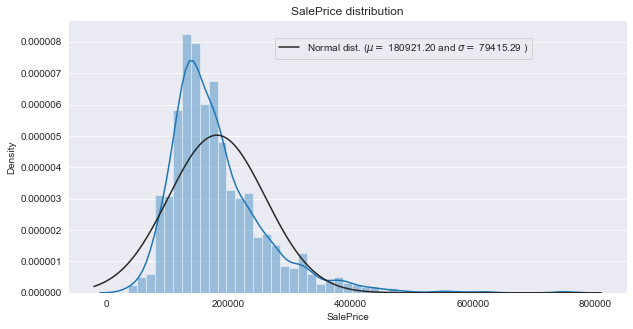

In [5]:
sns.set_style("darkgrid")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(10, 5))

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            bbox_to_anchor=(0.6, 0.9), loc="center")

ax.xaxis.grid(False)
ax.set(ylabel="Density")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")

sns.despine(trim=True, left=True)
plt.savefig("../fig/saleprice", bbox_inches = "tight")

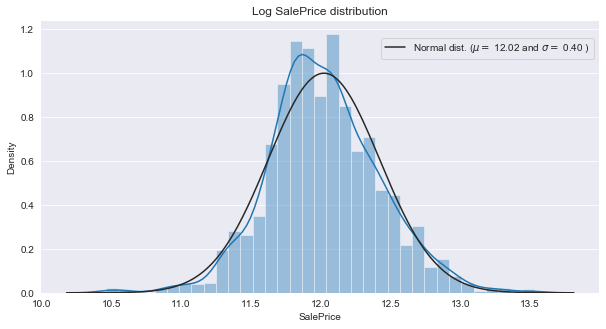

In [6]:
sns.set_style("darkgrid")
train["log_SalePrice"] = np.log1p(train["SalePrice"])

sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(10, 5))
#Check the new distribution 
sns.distplot(train['log_SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['log_SalePrice'])

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            bbox_to_anchor=(0.8, 0.9), loc="center")

ax.xaxis.grid(False)
ax.set(ylabel="Density")
ax.set(xlabel="SalePrice")
ax.set(title="Log SalePrice distribution")

sns.despine(trim=True, left=True)
plt.savefig("../fig/saleprice_log", bbox_inches = "tight")

As we can see from the sale price distribution, it is rightly skewed, meaning that there are some houses that is really expensive and some that is just lying in the normal distribution. It is best to have our label prices standardized as an outlier values can create some instability towards our regression model, meaning that it is not trained to actually see that value as there is only one or two data points that poses so. 

## Temporal Variables

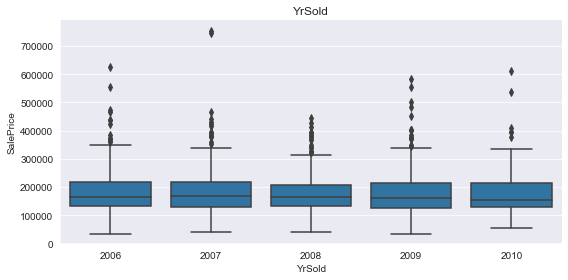

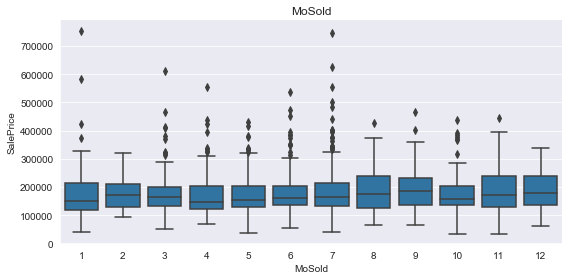

In [7]:
temporal_train = train[temporal]
for i in ["YrSold", "MoSold"]:
    if i == "SalePrice":
        continue
    if len(temporal_train[i].unique()) > 20:
        plt.figure(figsize = (50,10))
    else:
        plt.figure(figsize = (8,4))
    sns.boxplot(x = temporal_train[i], y = train["SalePrice"], color = current_palette[0])
    sns.despine()
    plt.title(i)
    plt.tight_layout()
    plt.savefig("../fig/%s"%i, bbox_inches = "tight")

As assessed from temporal variables, we do not see any seasonality towards when the house is being sold or which month it is, therefore we do not need to normalize based on inflation of house pricing. If this is the case, it is viable to reduce the temporal variables into smaller subset of variables, such as the age of the house, year since it last got remodelled, and the garage age itself. 

## Creating more Interesting Temporal Variables Features

In [8]:
train["houseAge"] = temporal_train["YrSold"] - temporal_train["YearBuilt"]
train["lastRemodelled"] = temporal_train["YrSold"] - temporal_train["YearRemodAdd"]
train["garageAge"] = temporal_train["YrSold"] - temporal_train["GarageYrBlt"]

if "houseAge" not in numerical_level:
    numerical_level.append("houseAge")
if "lastRemodelledAge" not in numerical_level:
    numerical_level.append("lastRemodelled")
if "garageAge" not in numerical_level:
    numerical_level.append("garageAge")
    
numerical = numerical + ["houseAge", "garageAge", "lastRemodelled"]

In [9]:
train["lastRemodelled"] = np.where(train["lastRemodelled"] < 0, 0, train["lastRemodelled"])

#### a. House Age Distribution

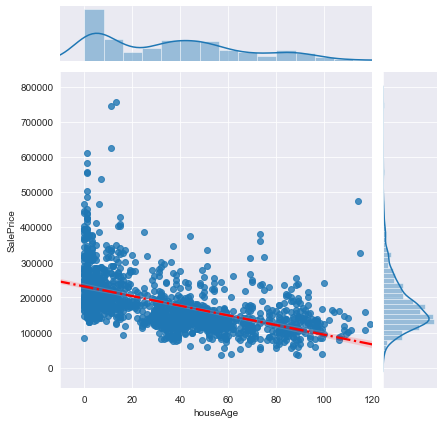

In [10]:
sns.set_style("darkgrid")
sns.jointplot(x = "houseAge", 
              y = "SalePrice", 
              data = train,
              kind = "reg", 
              joint_kws={'line_kws':{'color':'red', "linestyle":"-."}})
plt.xlim(-10,120)
plt.savefig("../fig/houseAge", bbox_inches = "tight")

#### b). Last Remodelled Distribution

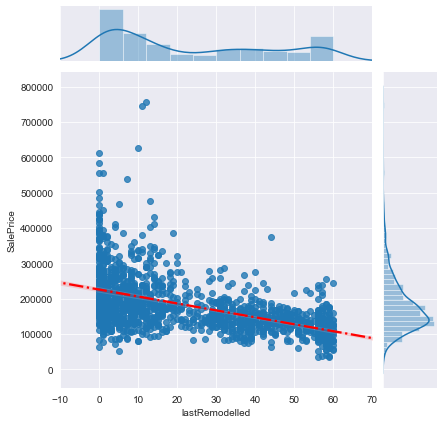

In [11]:
sns.set_style("darkgrid")
sns.jointplot(x = "lastRemodelled", 
              y = "SalePrice", 
              data = train,
              kind = "reg", 
              joint_kws={'line_kws':{'color':'red', "linestyle":"-."}})
plt.xlim(-10,70)
plt.savefig("../fig/lastRemodel", bbox_inches = "tight")

#### c). Garage Age Distribution

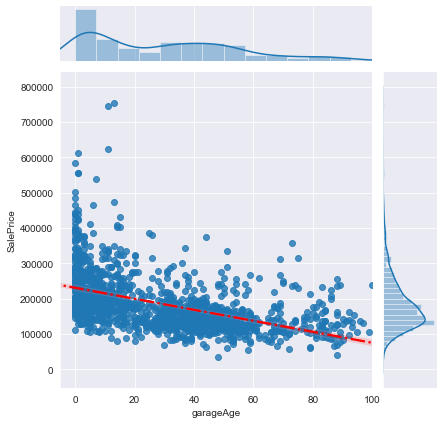

In [12]:
sns.set_style("darkgrid")
sns.jointplot(x = "garageAge", 
              y = "SalePrice", 
              data = train,
              kind = "reg", 
              joint_kws={'line_kws':{'color':'red', "linestyle":"-."}})
plt.xlim(-5, 100)
plt.savefig("../fig/garageAge", bbox_inches = "tight")

In terms of age distribution, we can say that most of our samples are clustered around age 0-10, meaning that the house is pretty recent in terms of their garages, remodelling, and house age itself. Note that there is an anomaly of 1 datapoint with -1 in the year sold and last remodelled, which doesnt make sense and will be replaced as 0.

## Assessment based on Sale Condition

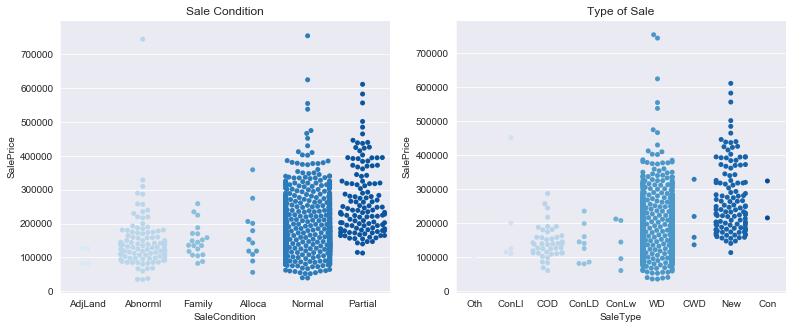

In [13]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (13,5))
sns.swarmplot(train['SaleCondition'].fillna("Missing"), 
            train["SalePrice"], 
            ax = axes[0], 
            order=train.groupby('SaleCondition').median().sort_values("SalePrice").index,
            palette="Blues")
sns.despine()
axes[0].set_title("Sale Condition")


sns.swarmplot(train['SaleType'].fillna("Missing"), 
            train["SalePrice"], 
            ax = axes[1], 
            order=train.groupby('SaleType').median().sort_values("SalePrice").index,
            palette="Blues")
sns.despine()
axes[1].set_title("Type of Sale")
fig.show()

plt.savefig("../fig/saleCondition", bbox_inches = "tight")

## Continuous Variable

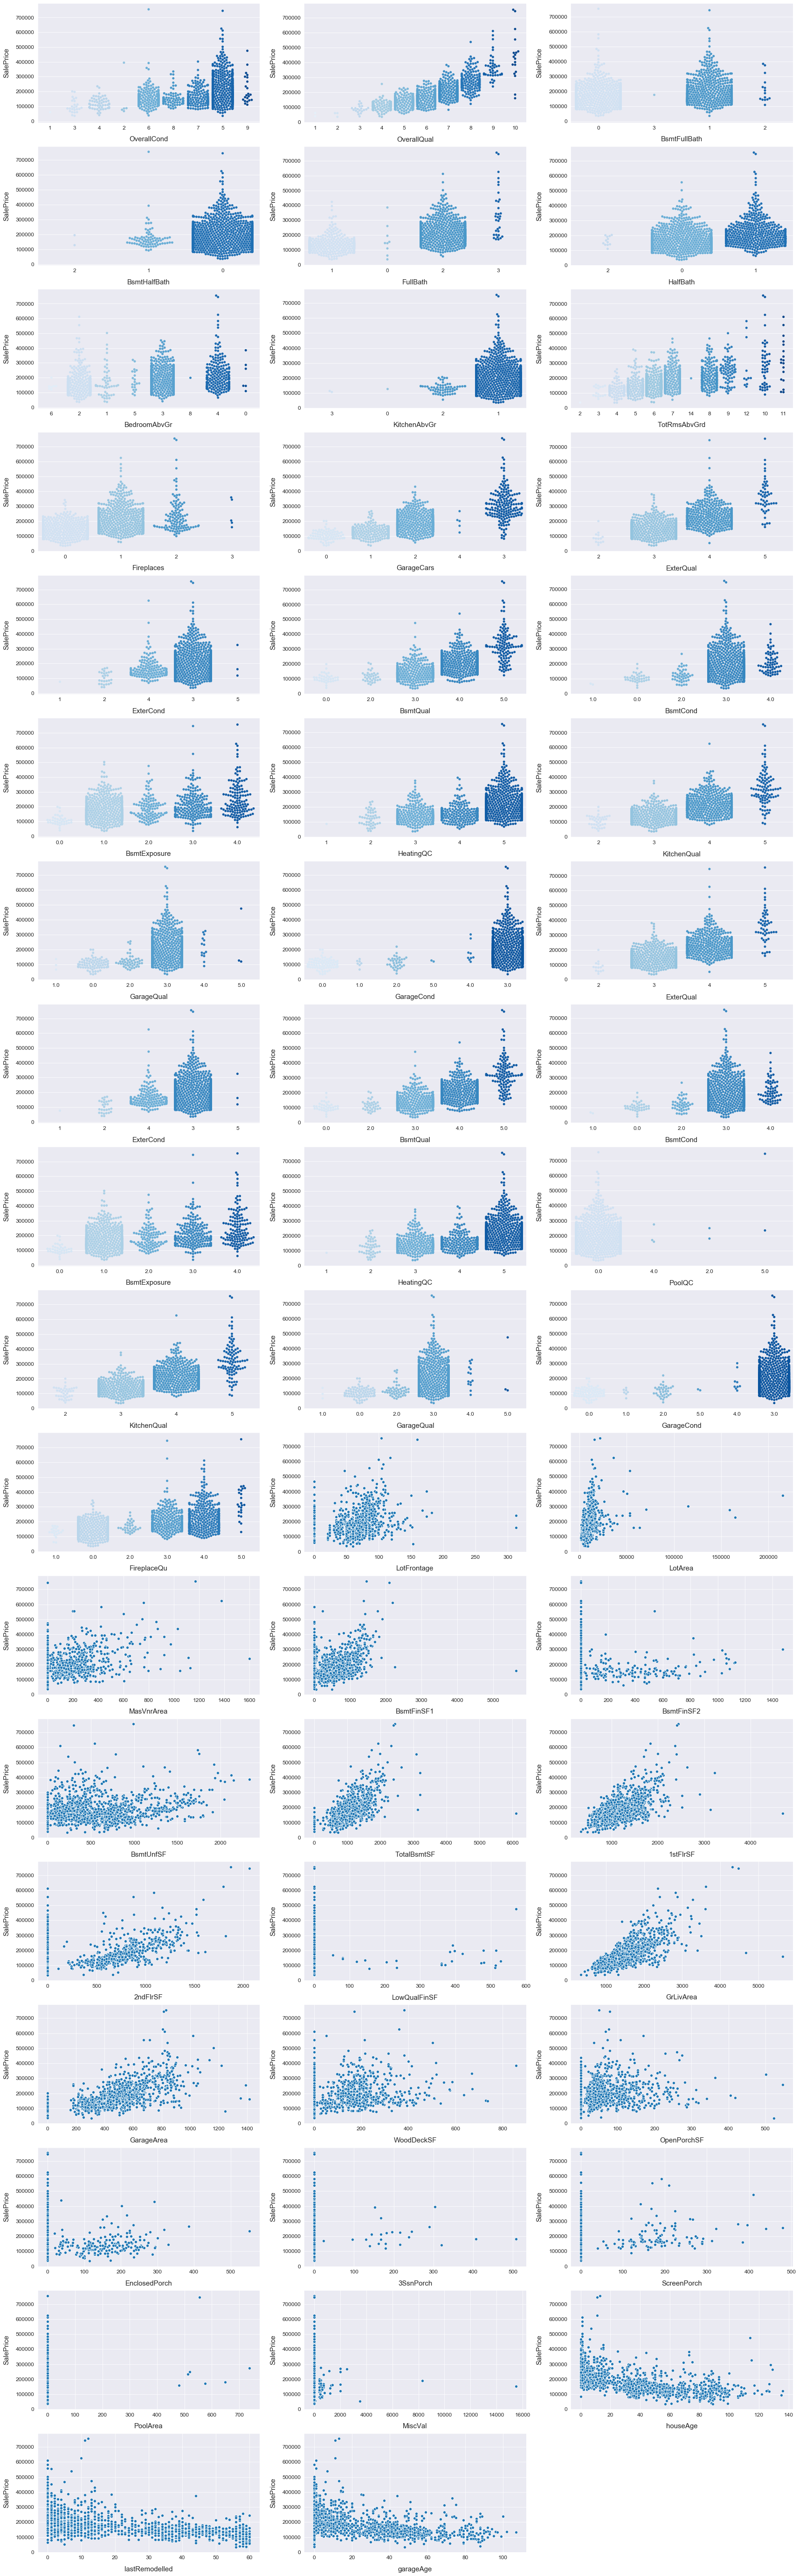

In [14]:
# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
for i, feature in enumerate(list(train[numerical_level]), 1):
    plt.subplot(len(list(numerical_level)), 3, i)
    temp = train.fillna(0)
    if feature in levels:
        idx = temp.groupby(feature).mean().sort_values("SalePrice").index
        sns.swarmplot(x=feature, 
                y='SalePrice', 
                data= temp,
                order = idx,
                palette = "Blues")
    else:
        sns.scatterplot(x=feature, 
                        y='SalePrice', 
                        data= temp,
                        palette = "Blues")
        
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    for _ in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)

plt.savefig("../fig/continuous", bbox_inches = "tight")

#### Analyzing Continuous Feature Relationship

In [15]:
numerical_level = list(set(numerical_level))

In [16]:
corr = pd.concat([train[["SalePrice"]], train[numerical_level]], axis = 1).corr(method = "spearman")

#### Spearman Correlation

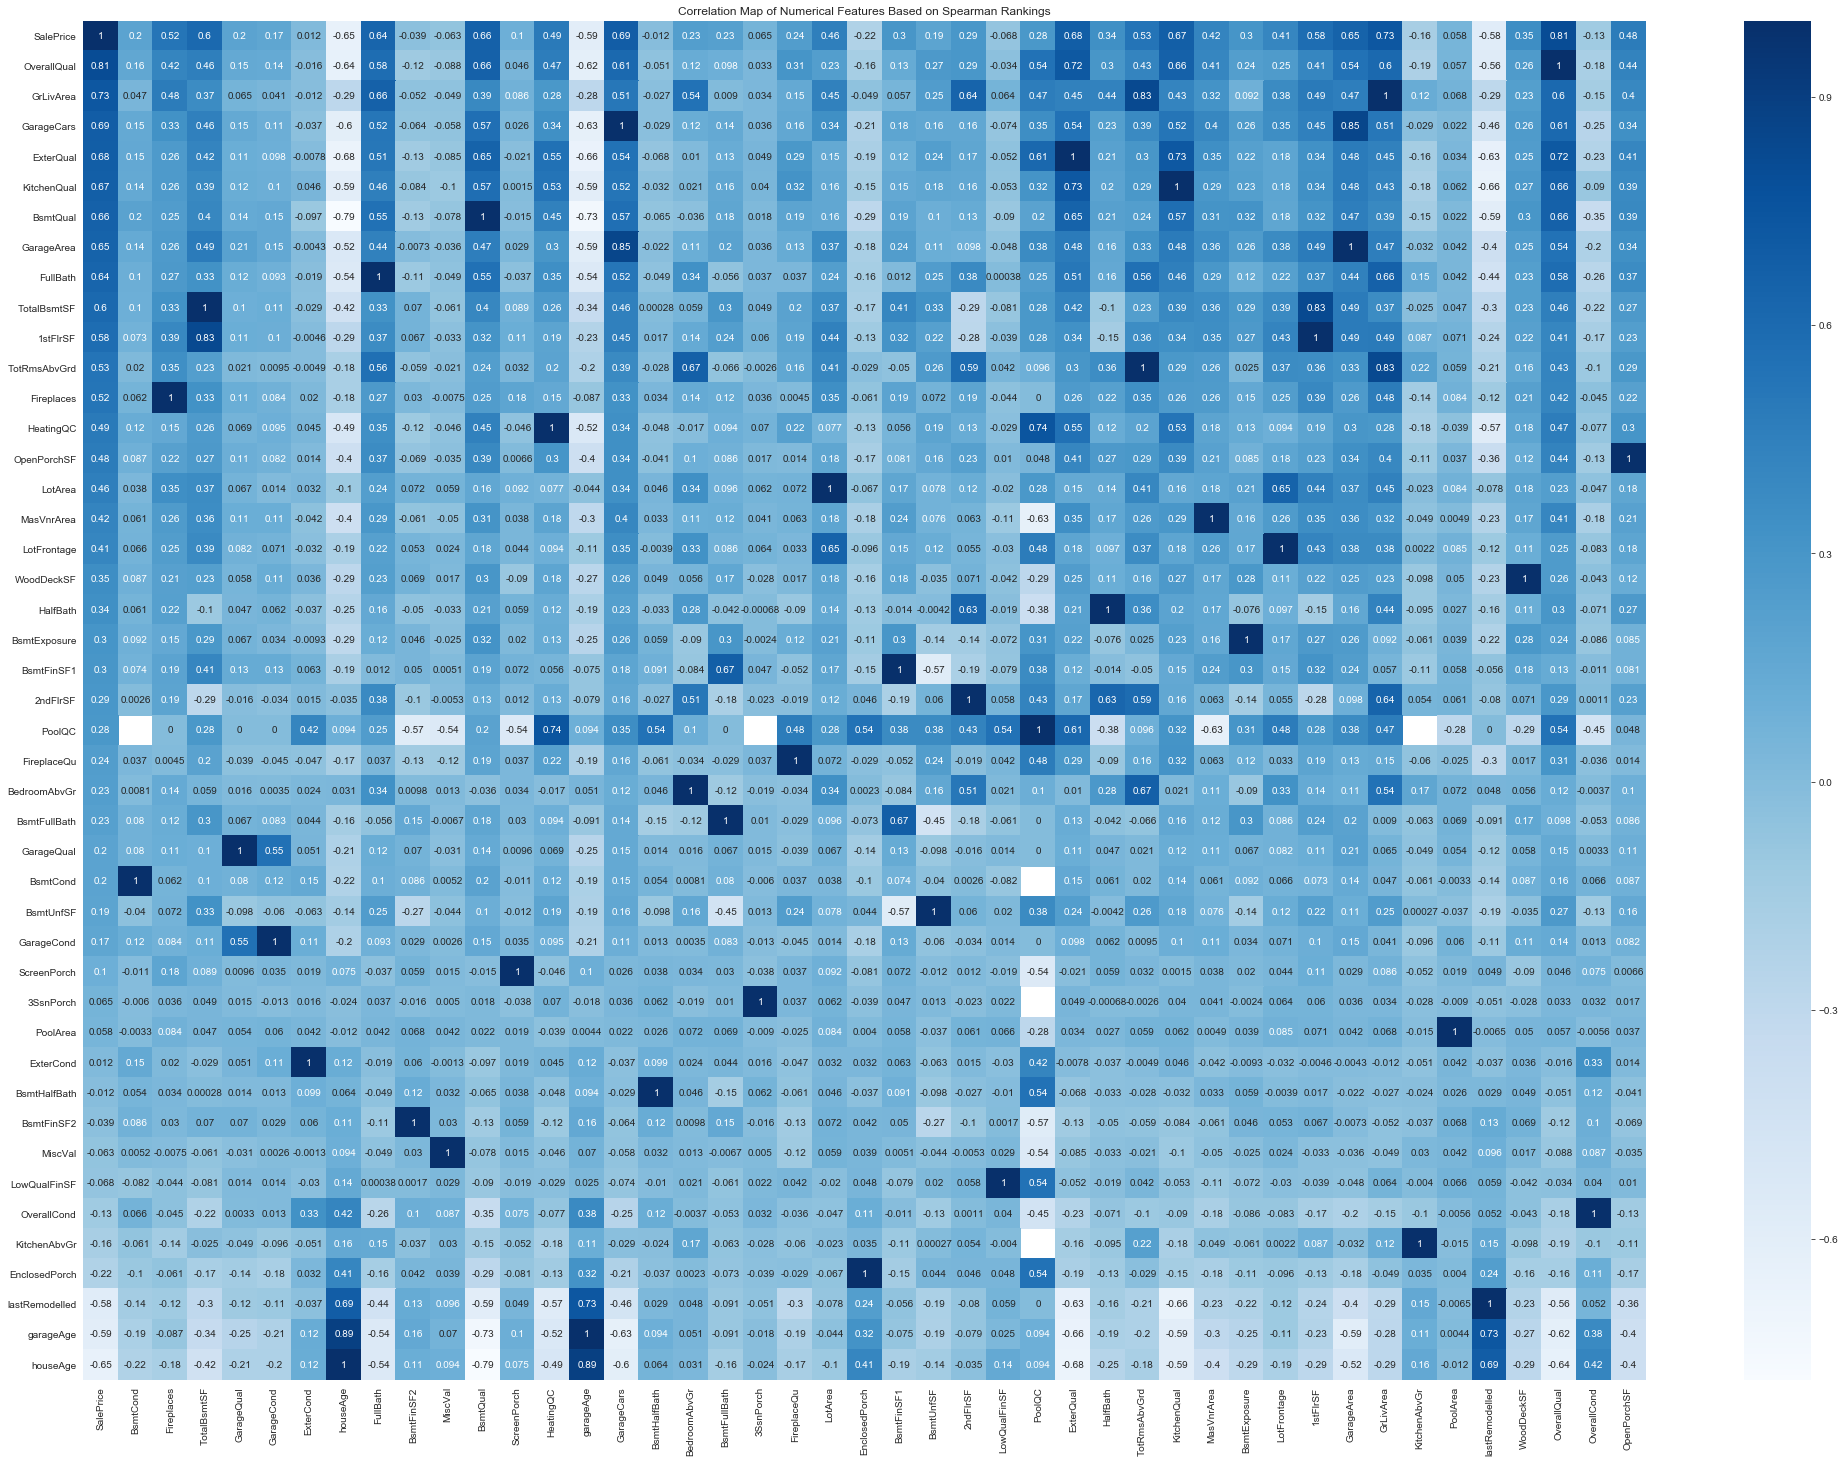

In [17]:
sns.set_style("white")
plt.figure(figsize = (35,25))
sns.heatmap(corr.sort_values("SalePrice", ascending = False),
            annot = True, cmap="Blues")
plt.title("Correlation Map of Numerical Features Based on Spearman Rankings")
plt.savefig("../fig/correlation", bbox_inches = "tight")

## Categorical Variables

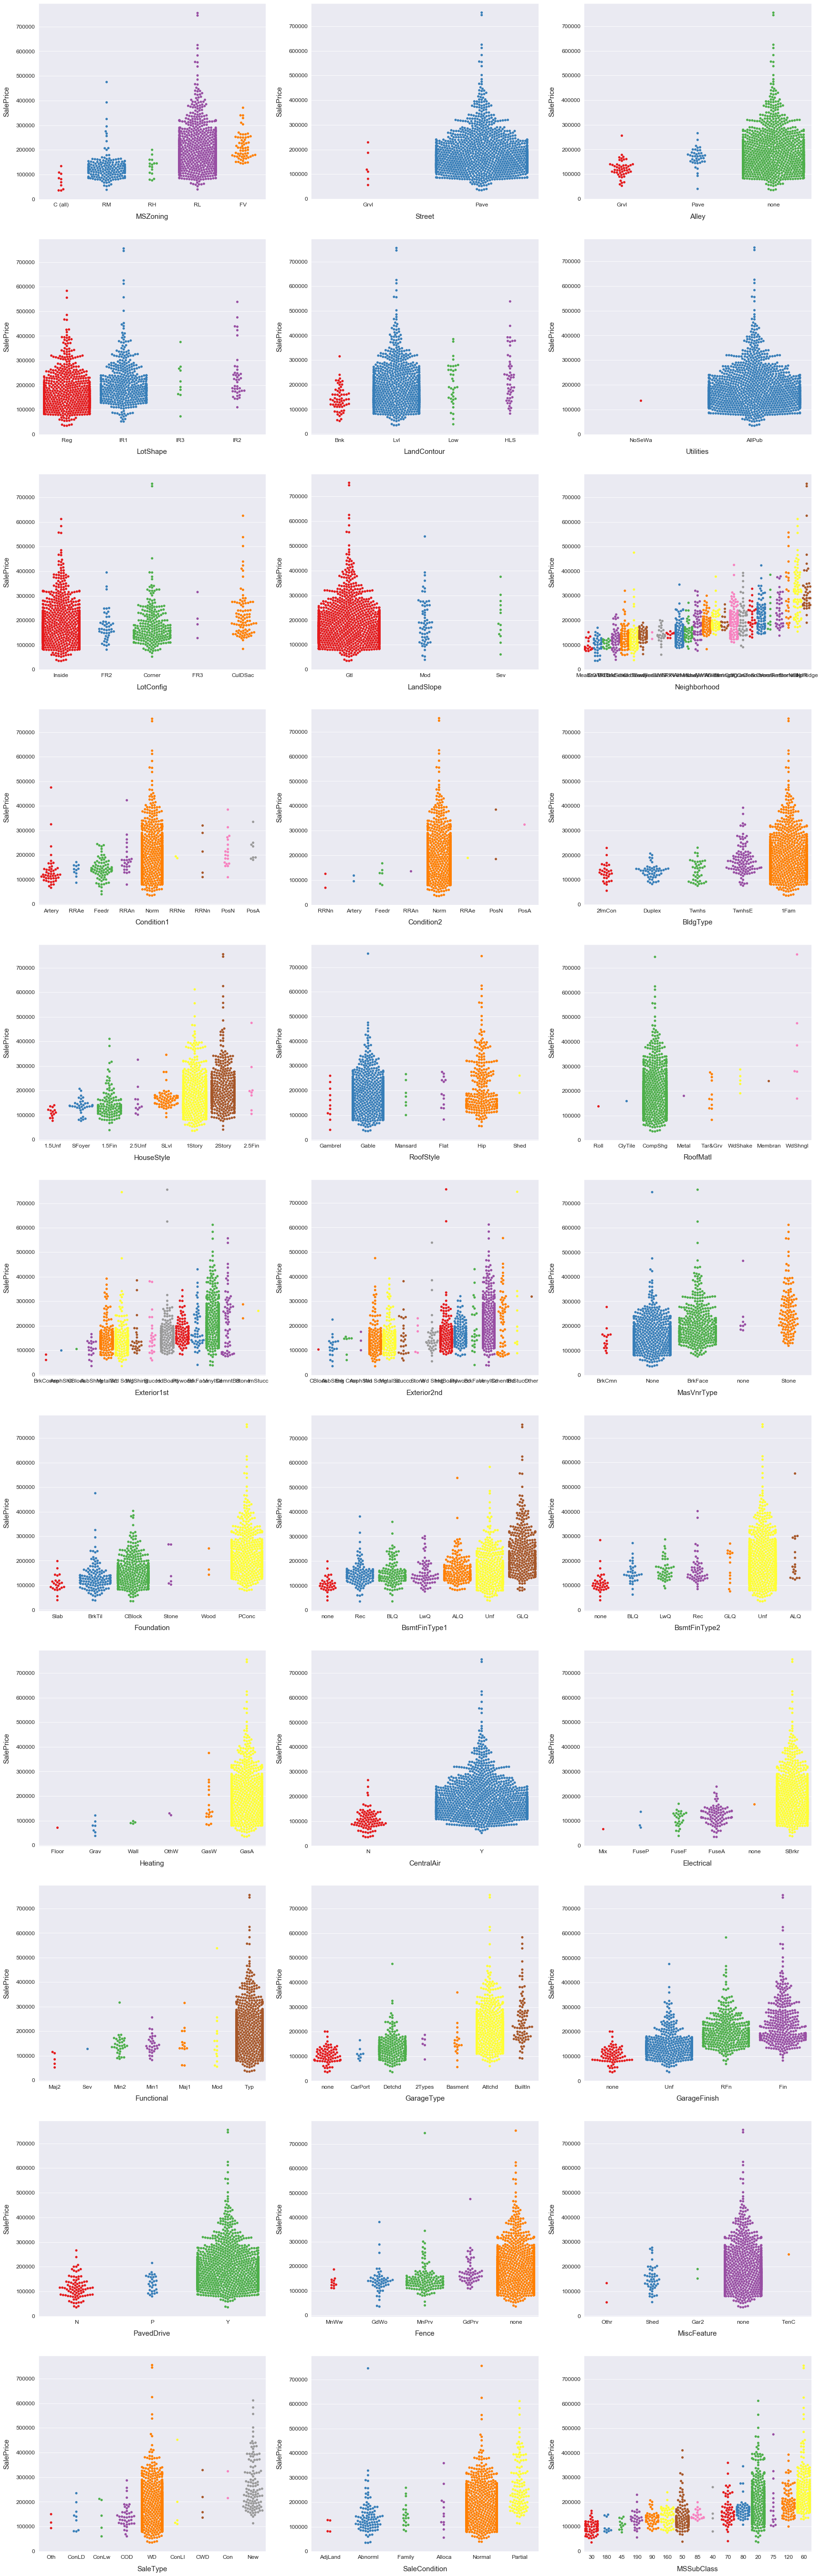

In [18]:
sns.set_style("darkgrid")

# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
for i, feature in enumerate(list(train[categorical]), 1):
    plt.subplot(len(list(categorical)), 3, i)
    temp = train.fillna("none")
    idx = temp.groupby(feature).mean().sort_values("SalePrice").index
    sns.swarmplot(x=feature, 
                y='SalePrice', 
                data= temp,
                palette = "Set1",
                order = idx) 
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    for _ in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
plt.savefig("../fig/categorical", bbox_inches = "tight")

### Assessing Outliers for Continuous Variables

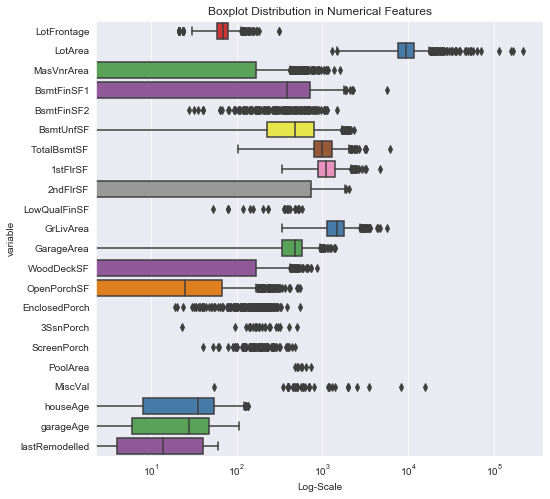

In [20]:
sns.set_style("darkgrid")

plt.figure(figsize = (8,8))
a = sns.boxplot(y = "variable", 
                x = "value",
                data= pd.melt(train[numerical]),
                palette="Set1", 
                orient = "h")

a.set_xscale("log")

plt.xlabel("Log-Scale")
plt.title("Boxplot Distribution in Numerical Features")
plt.savefig("../fig/cont_distb", bbox_inches = "tight")

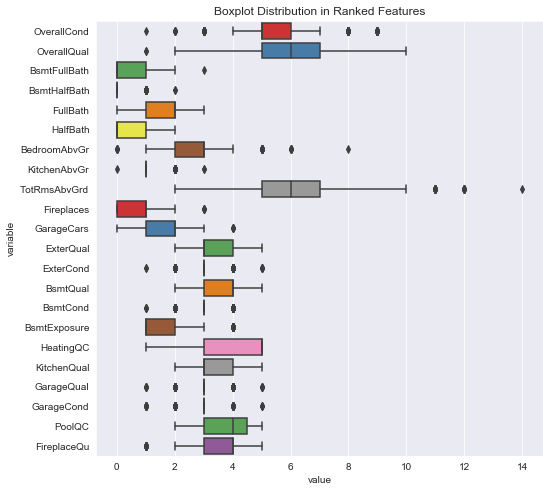

In [21]:
sns.set_style("darkgrid")

plt.figure(figsize = (8,8))
sns.boxplot(y = "variable", 
            x = "value",
            data= pd.melt(train[levels]),
            palette="Set1", 
            orient = "h")
plt.title("Boxplot Distribution in Ranked Features")
plt.savefig("../fig/levels_distb", bbox_inches = "tight")

#### After Standardization

In [22]:
normalize = MinMaxScaler()
scaled = pd.DataFrame(normalize.fit_transform(train[numerical_level].fillna(0)),columns = numerical_level)

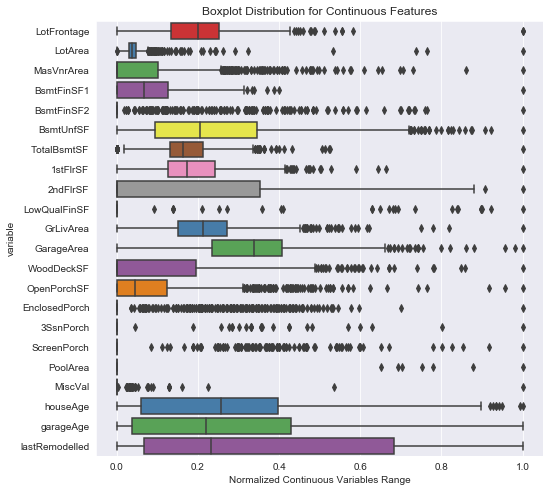

In [30]:
sns.set_style("darkgrid")

plt.figure(figsize = (8,8))
a = sns.boxplot(y = "variable", 
                x = "value",
                data= pd.melt(scaled[numerical]),
                palette="Set1", 
                orient = "h")
plt.xlabel("Normalized Continuous Variables Range")
plt.title("Boxplot Distribution for Continuous Features")
plt.savefig("../fig/norm_cont_distb", bbox_inches = "tight")

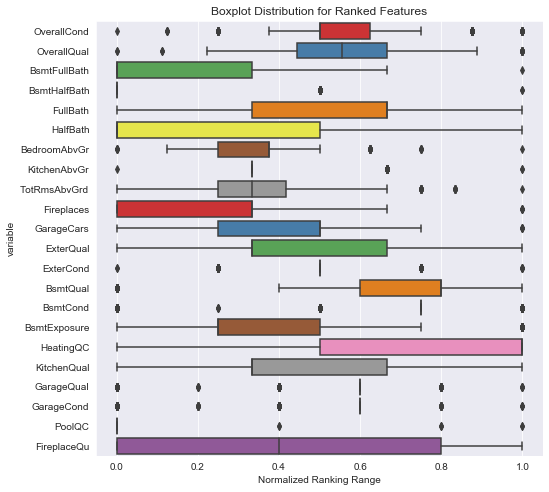

In [31]:
sns.set_style("darkgrid")

plt.figure(figsize = (8,8))
a = sns.boxplot(y = "variable", 
                x = "value",
                data= pd.melt(scaled[levels]),
                palette="Set1", 
                orient = "h")
plt.xlabel("Normalized Ranking Range")
plt.title("Boxplot Distribution for Ranked Features")
plt.savefig("../fig/rank_cont_distb", bbox_inches = "tight")

### Baseline Prediction 


In determinining the baseline of the prediction, we would like to use the numerical features without any preprocessing, as well as treating the categorical variables as dummy variables. Afterwards, this will be the baseline to assess whether we are actually creating value through the feature engineering process.

In [27]:
var = set(numerical_level + categorical)

X_train, X_test, y_train, y_test = train_test_split(train[var], train["SalePrice"], 
                                                    test_size=0.25, random_state=100)
X_train, X_test = fill_zero(X_train, X_test, numerical_level)
X_train, X_test = fill_with_missing(X_train, X_test, categorical)
X_train, X_test = one_hot_encoding(X_train, X_test, categorical)

In [29]:
results = assess_performance(X_train, X_test, y_train, y_test)
pd.DataFrame({"model" :results[0]["model"],
              "8cv_rmse_log_label": np.mean(results[0]["rmse"], axis = 1),
              "test_rmse_adjusted": list(results[1].values())})

model  8cv_rmse_log_label  test_rmse_adjusted
0          lasso        51501.704672        36705.318113
1          ridge        34444.459055        29218.172820
2  gradientboost        29193.468915        25598.963307
3   randomforest        30819.390124        30292.154131